In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/Users/awxlong/Desktop/my-studies/hpc_exps/')

In [30]:
from HistoMIL.DATA.Slide.concepts.feature import Features
from HistoMIL.EXP.paras.env import EnvParas


In [31]:
preprocess_env = EnvParas()

machine_cohort_loc = "/Users/awxlong/Desktop/my-studies/hpc_exps/User/CRC_machine_config.pkl"
with open(machine_cohort_loc, "rb") as f:   # Unpickling
    [data_locs,exp_locs,machine,user] = pickle.load(f)
preprocess_env.data_locs = data_locs
preprocess_env.exp_locs = exp_locs

In [32]:
preprocess_env.collector_para.feature

FeatureParas(model_name='resnet18', device='mps', trans=<function only_naive_transforms at 0x360806ee0>, batch_size=32, cluster_nb=200, with_semantic_shifts=False)

In [33]:
clinical_root = "/Users/awxlong/Desktop/my-studies/temp_data/COAD/Feature/clinical/"


In [34]:
test_df = pd.read_csv(os.path.join(clinical_root, 'test', 'test.csv'))
# test_df.to_csv('test_set.csv')
test_df.shape

(58, 30)

In [35]:
[col for col in test_df.columns if col.startswith('Pathologic')]
# [col for col in test_df.columns]

['Pathologic Stage_Stage II',
 'Pathologic Stage_Stage IIA',
 'Pathologic Stage_Stage IIB',
 'Pathologic Stage_Stage III',
 'Pathologic Stage_Stage IIIB',
 'Pathologic Stage_Stage IIIC',
 'Pathologic Stage_Stage IV',
 'Pathologic Stage_Stage IVA']

In [36]:
stage_i_patient_ids = ['TCGA-AZ-5407',
 'TCGA-AA-3553',
 'TCGA-D5-6530',
 'TCGA-CK-5916',
 'TCGA-AA-A00R',
 'TCGA-AG-3726',
 'TCGA-DC-6158',
 'TCGA-AF-6655']

In [37]:
stage_i_mask = test_df['PatientID'].isin(stage_i_patient_ids)

In [38]:
early_stage_mask = (
    (test_df['Pathologic Stage_Stage II'] == 1) |
    (test_df['Pathologic Stage_Stage IIA'] == 1) |
    (test_df['Pathologic Stage_Stage IIB'] == 1) |
    (stage_i_mask)
)

# Get Early Stage Patient IDs
early_stage_patient_ids = test_df.loc[early_stage_mask,  ['PatientID', 'g0_arrest']].drop_duplicates()

# Create a mask for Late Stage Patients
late_stage_mask = (
    (test_df['Pathologic Stage_Stage III'] == 1) |
    (test_df['Pathologic Stage_Stage IIIB'] == 1) |
    (test_df['Pathologic Stage_Stage IIIC'] == 1) |
    (test_df['Pathologic Stage_Stage IV'] == 1) |
    (test_df['Pathologic Stage_Stage IVA'] == 1)
)

# Get Late Stage Patient IDs
late_stage_patient_ids = test_df.loc[late_stage_mask, ['PatientID', 'g0_arrest']].drop_duplicates()

# Output the results
print("Early Stage PatientIDs:")
print(early_stage_patient_ids)

print("\nLate Stage PatientIDs:")
print(late_stage_patient_ids)

# Combine early and late stage patient IDs with their labels
combined_df = pd.concat([early_stage_patient_ids, late_stage_patient_ids])

# Create a new column to indicate the stage
combined_df['Stage'] = combined_df.apply(
    lambda row: 'Early' if row['PatientID'] in (early_stage_patient_ids['PatientID'].values) else 'Late',
    axis=1
)

Early Stage PatientIDs:
       PatientID  g0_arrest
0   TCGA-AD-6963          0
2   TCGA-AY-6197          0
3   TCGA-D5-6536          1
4   TCGA-5M-AAT5          1
5   TCGA-CM-6679          0
6   TCGA-AZ-5407          1
7   TCGA-5M-AATE          1
9   TCGA-CM-5860          0
10  TCGA-AA-3553          0
11  TCGA-A6-4105          0
15  TCGA-G4-6304          1
17  TCGA-AA-3532          0
18  TCGA-AA-3555          1
24  TCGA-D5-6530          1
25  TCGA-AA-3531          1
26  TCGA-AA-3710          0
27  TCGA-AA-A01Q          1
29  TCGA-AA-3489          0
31  TCGA-DM-A1D9          1
32  TCGA-G4-6627          0
34  TCGA-AA-3856          0
35  TCGA-SS-A7HO          1
36  TCGA-DM-A1D6          1
38  TCGA-CK-5916          0
40  TCGA-AA-A00R          0
41  TCGA-EI-6507          0
44  TCGA-AG-3726          1
47  TCGA-AH-6544          1
52  TCGA-EI-6506          0
54  TCGA-DC-6158          0
56  TCGA-CL-5918          0
57  TCGA-AF-6655          0

Late Stage PatientIDs:
       PatientID  g0_arrest


In [39]:
print(combined_df.shape)
print(combined_df.head(10))
print(combined_df.tail(10))

(58, 3)
       PatientID  g0_arrest  Stage
0   TCGA-AD-6963          0  Early
2   TCGA-AY-6197          0  Early
3   TCGA-D5-6536          1  Early
4   TCGA-5M-AAT5          1  Early
5   TCGA-CM-6679          0  Early
6   TCGA-AZ-5407          1  Early
7   TCGA-5M-AATE          1  Early
9   TCGA-CM-5860          0  Early
10  TCGA-AA-3553          0  Early
11  TCGA-A6-4105          0  Early
       PatientID  g0_arrest Stage
42  TCGA-AG-A032          1  Late
43  TCGA-DC-5869          0  Late
45  TCGA-EI-6508          1  Late
46  TCGA-DC-4745          0  Late
48  TCGA-AG-3909          1  Late
49  TCGA-AG-3727          1  Late
50  TCGA-AG-3583          1  Late
51  TCGA-AG-4021          1  Late
53  TCGA-AF-2690          0  Late
55  TCGA-AH-6643          0  Late


In [40]:
# stage_i_patient_ids = [pid for pid in test_df['PatientID'] if pid not in combined_df['PatientID'].values]


In [41]:
# pids = [pid for pid in test_df['PatientID'] if pid not in combined_df['PatientID'].values]
# test_df[test_df['PatientID'].isin(pids)].loc[:, ['PatientID', 'g0_arrest']]

In [42]:
# stage_i_patient_ids

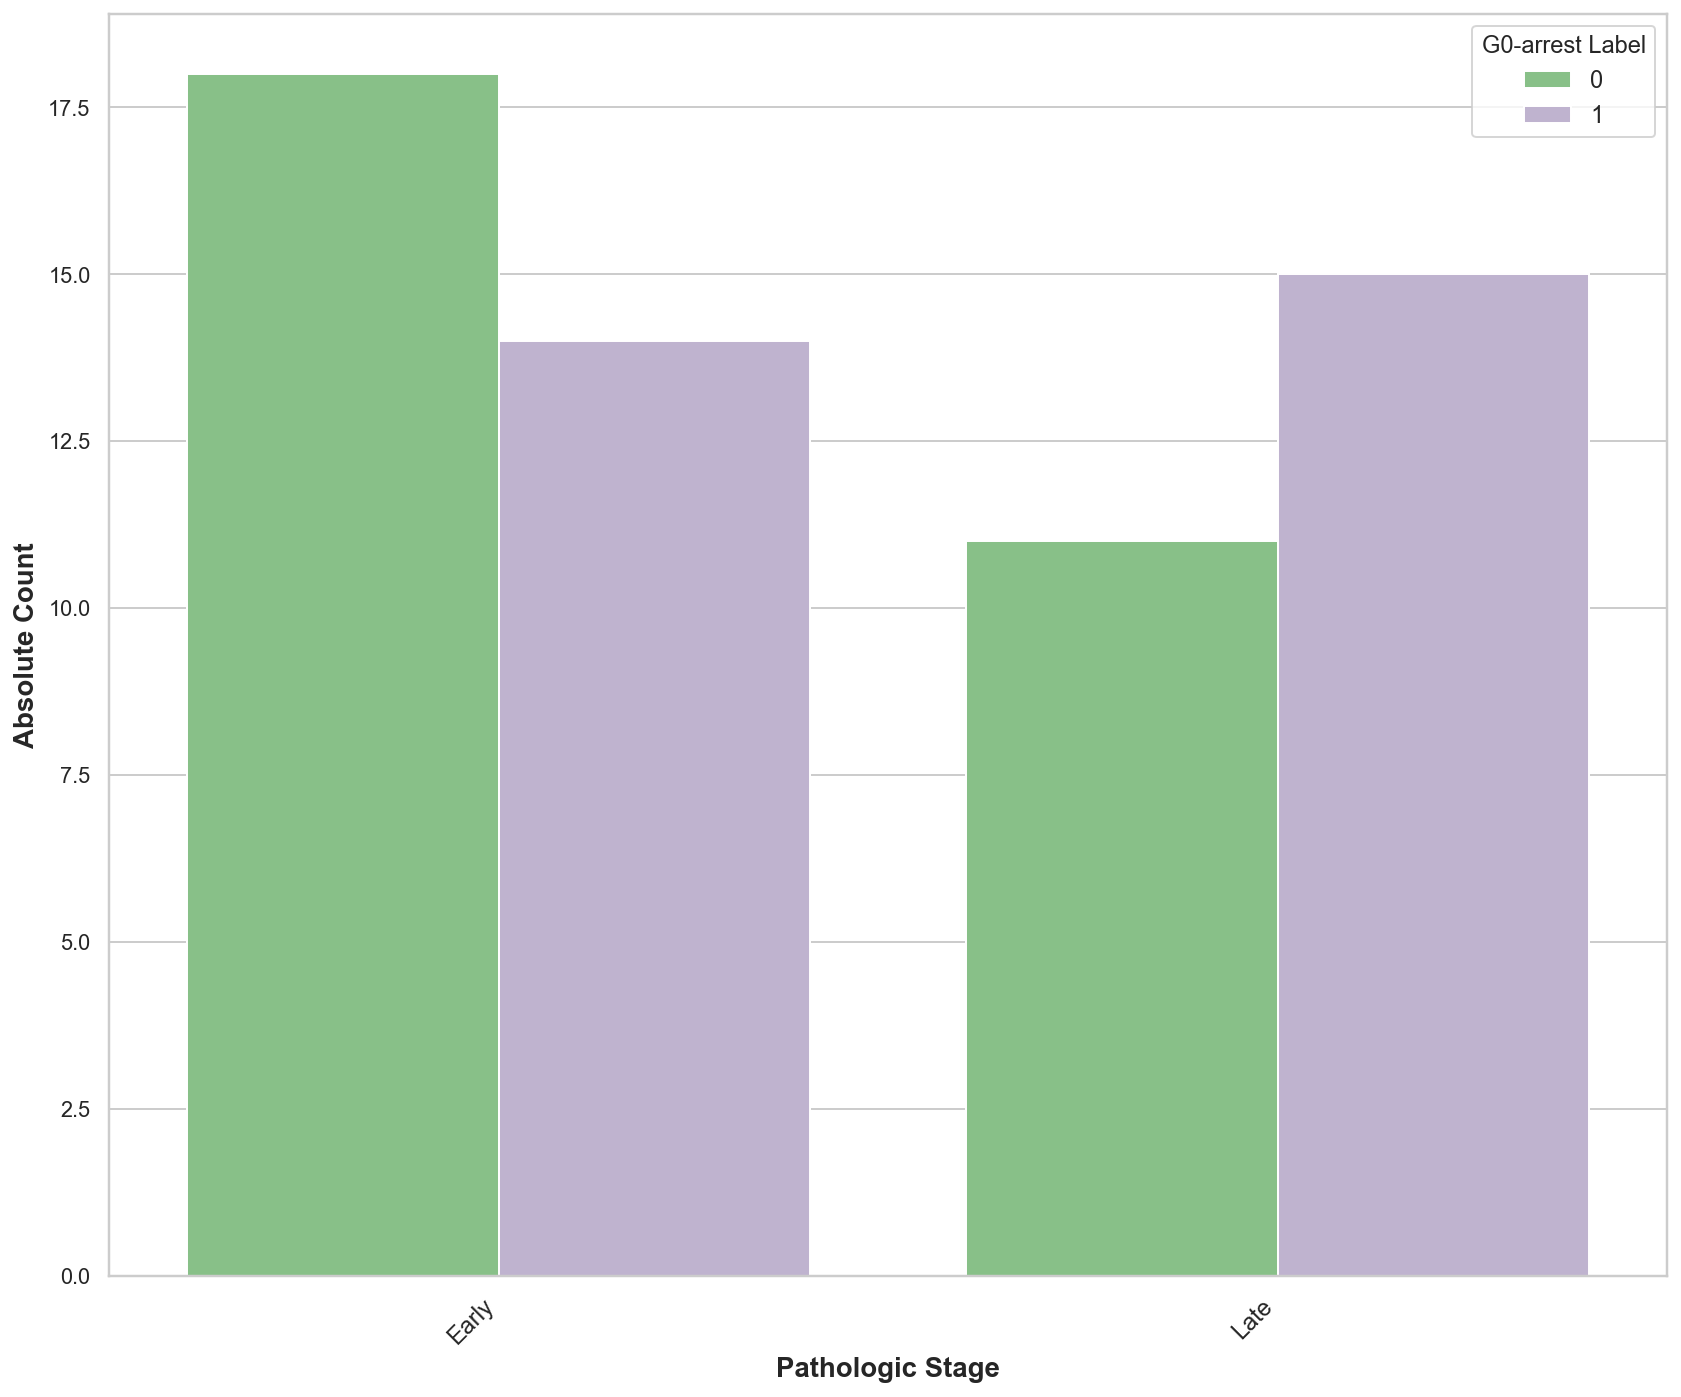

In [43]:


# Set the aesthetics for the plot
plt.figure(figsize=(12, 10), dpi=142)
sns.set_theme(style="whitegrid")
custom_palette = {'early': 'blue', 'late': 'red'}
# Create a count plot to visualize the distribution of G0-arrest labels per pathologic stage
sns.countplot(x='Stage', hue='g0_arrest', data=combined_df, palette='Accent')

# Customize the plot with titles and labels
# plt.title('Distribution of G0-arrest Labels per Pathologic Stage', fontsize=16, fontweight='bold')
plt.xlabel('Pathologic Stage', fontsize=14, fontweight='bold')
plt.ylabel('Absolute Count', fontsize=14, fontweight='bold')
plt.legend(title='G0-arrest Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [44]:
df = pd.read_csv('/Users/awxlong/Desktop/my-studies/hpc_exps/OutFilesALL/ensemble_res_TransMILMultimodal_uni_continuous.csv')

In [45]:
joined_df = pd.concat([test_df, df], axis=1)
joined_df.shape

(58, 34)

In [46]:
# Get Early Stage Patient IDs
early_stage_patient_ids = joined_df.loc[early_stage_mask,  ['PatientID', 'g0_arrest', 'ensemble_preds']].drop_duplicates()

# Get Late Stage Patient IDs
late_stage_patient_ids = joined_df.loc[late_stage_mask, ['PatientID', 'g0_arrest', 'ensemble_preds']].drop_duplicates()

# Output the results
print("Early Stage PatientIDs:")
print(early_stage_patient_ids)

print("\nLate Stage PatientIDs:")
print(late_stage_patient_ids)

# Combine early and late stage patient IDs with their labels
combined_df = pd.concat([early_stage_patient_ids, late_stage_patient_ids])

# Create a new column to indicate the stage
combined_df['Stage'] = combined_df.apply(
    lambda row: 'Early' if row['PatientID'] in (early_stage_patient_ids['PatientID'].values) else 'Late',
    axis=1
)

Early Stage PatientIDs:
       PatientID  g0_arrest  ensemble_preds
0   TCGA-AD-6963          0               0
2   TCGA-AY-6197          0               0
3   TCGA-D5-6536          1               0
4   TCGA-5M-AAT5          1               0
5   TCGA-CM-6679          0               0
6   TCGA-AZ-5407          1               0
7   TCGA-5M-AATE          1               1
9   TCGA-CM-5860          0               1
10  TCGA-AA-3553          0               0
11  TCGA-A6-4105          0               0
15  TCGA-G4-6304          1               0
17  TCGA-AA-3532          0               0
18  TCGA-AA-3555          1               1
24  TCGA-D5-6530          1               0
25  TCGA-AA-3531          1               1
26  TCGA-AA-3710          0               0
27  TCGA-AA-A01Q          1               0
29  TCGA-AA-3489          0               1
31  TCGA-DM-A1D9          1               0
32  TCGA-G4-6627          0               1
34  TCGA-AA-3856          0               0
35  TCGA

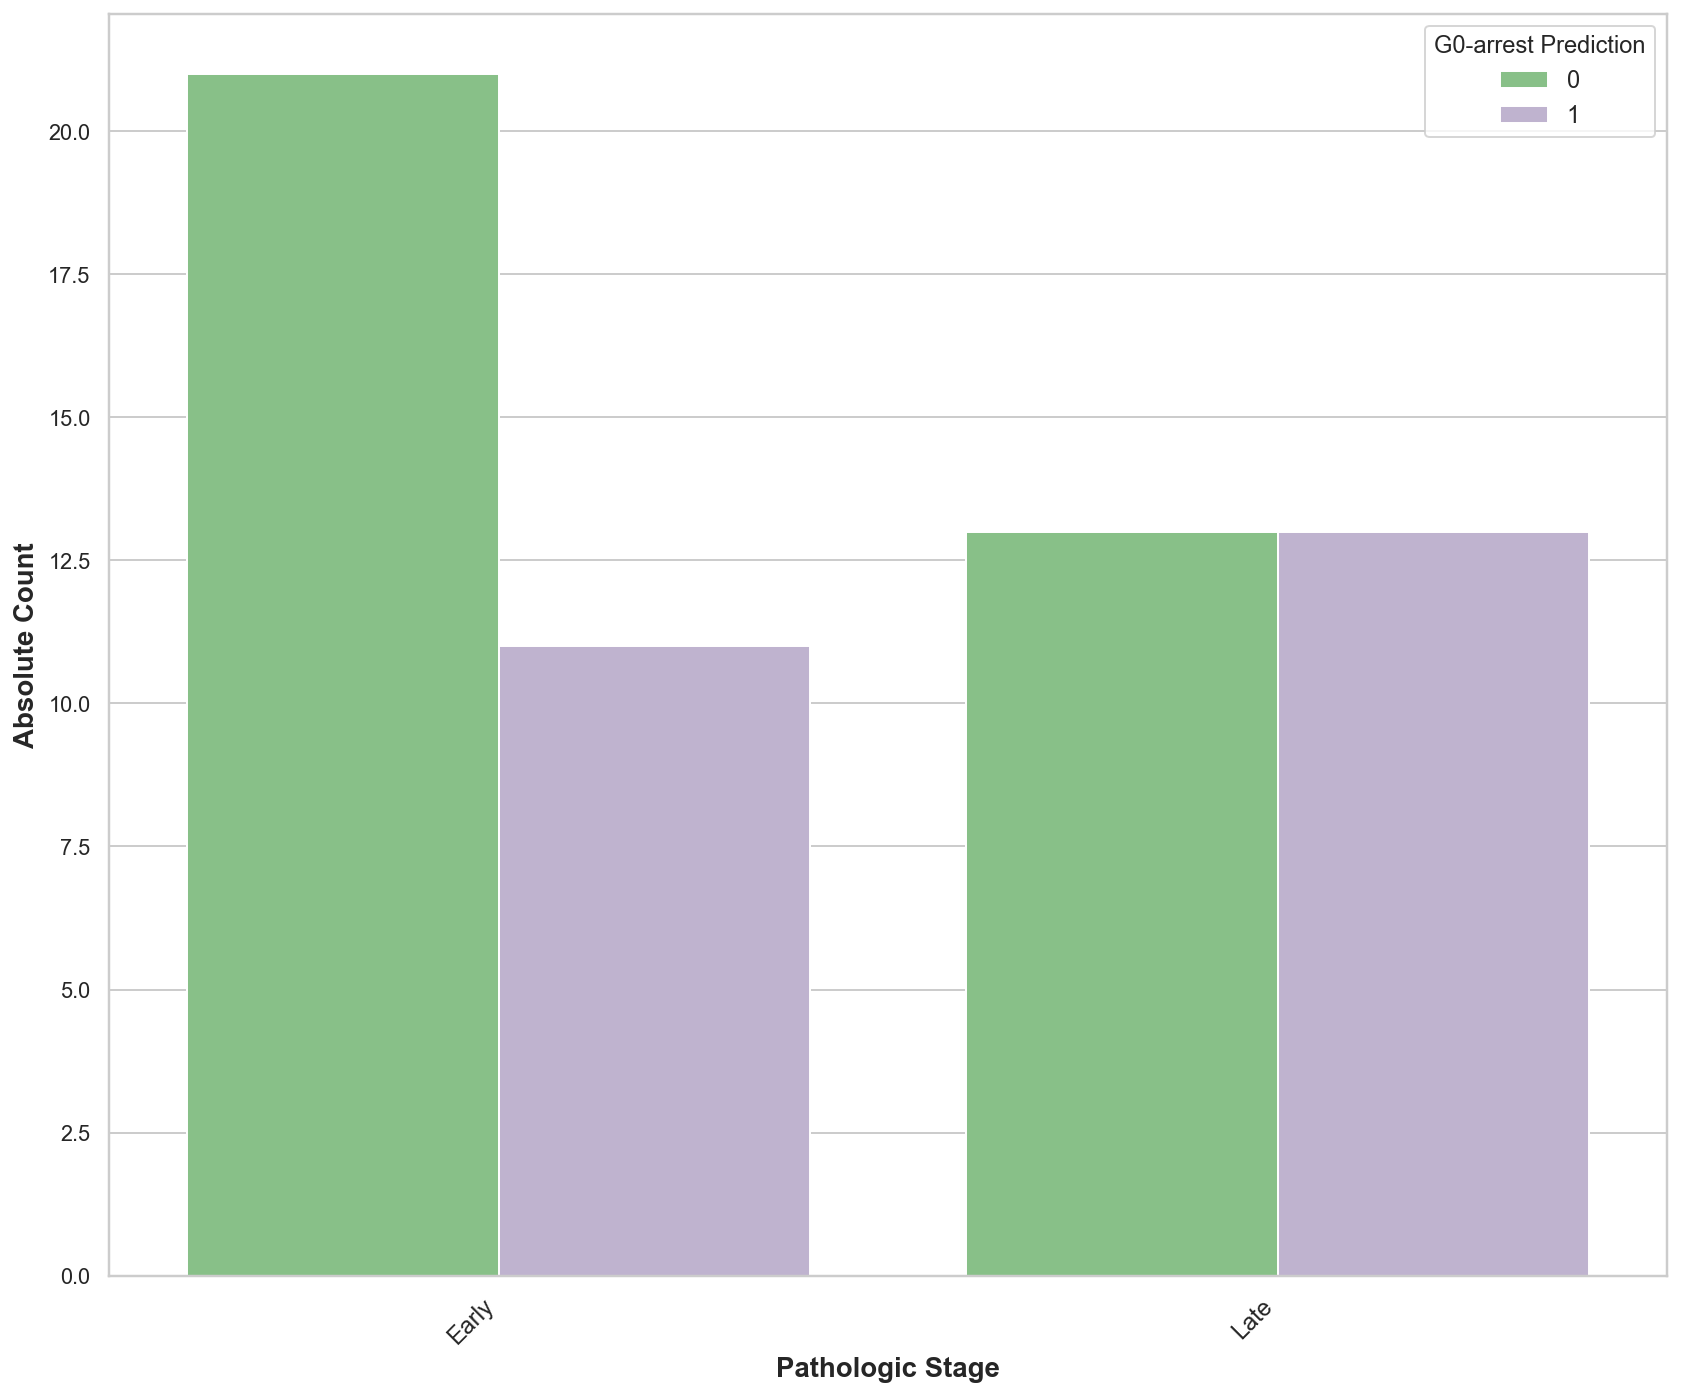

In [47]:


# Set the aesthetics for the plot
plt.figure(figsize=(12, 10), dpi=142)
sns.set_theme(style="whitegrid")

# Create a count plot to visualize the distribution of G0-arrest labels per pathologic stage
sns.countplot(x='Stage', hue='ensemble_preds', data=combined_df, palette='Accent')

# Customize the plot with titles and labels
# plt.title('Distribution of G0-arrest Predictions per Pathologic Stage', fontsize=16, fontweight='bold')
plt.xlabel('Pathologic Stage', fontsize=14, fontweight='bold')
plt.ylabel('Absolute Count', fontsize=14, fontweight='bold')
plt.legend(title='G0-arrest Prediction', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()